In [12]:
import glob
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def process_one_dataset(num_peers, seed):
    file_pattern = f'../results/{num_peers}/{seed}/ifstat_*.log'
    file_paths = sorted(glob.glob(file_pattern))

    all_sums = []  # This will contain N lists (one per file)
    for file_path in file_paths:

        file_sums = []  # Sum of the two floats per line
        with open(file_path, 'r') as f:
            # Skip first two lines
            next(f, None)
            next(f, None)
            
            # Process remaining lines
            for line in f:
                parts = line.strip().split()
                
                # Check if line has exactly two values that can be converted to float
                if len(parts) == 2:
                    try:
                        val1 = float(parts[0])
                        val2 = float(parts[1])
                        # Add the two values line-by-line
                        file_sums.append(val1 + val2)
                    except ValueError:
                        # Stop reading this file if we can't parse two floats
                        break
                else:
                    # Stop reading this file if line doesn't have two values
                    break
        
        all_sums.append(file_sums)

    # Step 3: Calculate average at each index across all files
    # Find the minimum length to ensure all files have data at each index
    min_length = min(len(sums) for sums in all_sums)

    # Calculate averages at each index
    averaged_netuse = []
    for i in range(min_length):
        # Get the value at index i from each file
        values_at_index = [file_sums[i] for file_sums in all_sums]
        # Calculate average
        avg = np.mean(values_at_index)
        averaged_netuse.append(avg)
    return averaged_netuse

In [14]:
all_results = [process_one_dataset(10, seed) for seed in range(0, 10)]

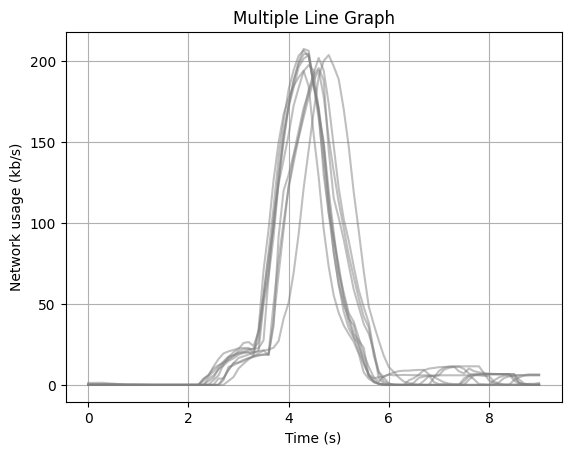

In [15]:
# Plot each list as a separate line
window = 10

for i, line_data in enumerate(all_results):
    x_values = [0.1 * idx for idx in range(len(line_data))][:(1-window)]
    plt.plot(x_values, np.convolve(line_data, np.ones(window)/window, mode='valid'), color='gray', alpha=0.5)

plt.xlabel('Time (s)')
plt.ylabel('Network usage (kb/s)')
plt.title('Multiple Line Graph')
plt.grid(True)
plt.savefig('plot.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#==============================================
NUM_PEERS = 10
SEED = 0

In [ ]:
# Step 1: Read all ifstat_*.log files
file_pattern = f'../results/{NUM_PEERS}/{SEED}/ifstat_*.log'
file_paths = sorted(glob.glob(file_pattern))

print(f"Found {len(file_paths)} files:")

In [ ]:
# Step 2: Parse each file and create lists of sums
all_sums = []  # This will contain N lists (one per file)

for file_path in file_paths:
    file_sums = []  # Sum of the two floats per line
    
    with open(file_path, 'r') as f:
        # Skip first two lines
        next(f, None)
        next(f, None)
        
        # Process remaining lines
        for line in f:
            parts = line.strip().split()
            
            # Check if line has exactly two values that can be converted to float
            if len(parts) == 2:
                try:
                    val1 = float(parts[0])
                    val2 = float(parts[1])
                    # Add the two values line-by-line
                    file_sums.append(val1 + val2)
                except ValueError:
                    # Stop reading this file if we can't parse two floats
                    break
            else:
                # Stop reading this file if line doesn't have two values
                break
    
    all_sums.append(file_sums)

In [ ]:
# Step 3: Calculate average at each index across all files
# Find the minimum length to ensure all files have data at each index
min_length = min(len(sums) for sums in all_sums)

# Calculate averages at each index
averaged_netuse = []
for i in range(min_length):
    # Get the value at index i from each file
    values_at_index = [file_sums[i] for file_sums in all_sums]
    # Calculate average
    avg = np.mean(values_at_index)
    averaged_netuse.append(avg)

In [ ]:
# Create the plot
plt.plot(averaged_netuse)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Line Graph')
plt.grid(True)
plt.savefig('plot.jpg', bbox_inches='tight')